In [257]:
from google.colab import files
uploaded = files.upload()


Saving speaker1.mp3 to speaker1.mp3
Saving speaker2.mp3 to speaker2.mp3
Saving speaker3.mp3 to speaker3.mp3
Saving speaker4.mp3 to speaker4.mp3
Saving speaker5.mp3 to speaker5.mp3


In [290]:
!pip install pydub
!pip install soundfile

In [1]:
import subprocess
from pydub import silence
from pydub import AudioSegment
from wave import open as open_wave
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import librosa
from librosa import display
import glob
import math
import random
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.applications import vgg16

/home/rishabh/miniconda3/envs/env3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
segment_length= 5000
n_mels = 128

In [3]:
import os
import glob
import subprocess
import shutil
import scipy
import soundfile as sf
from pydub import AudioSegment

In [104]:
classes=0
for file in glob.glob('./data/*'):
    i=0
    classes+=1
    for file1 in glob.glob(file + '/*'):
        for file2 in glob.glob(file1 + '/*'):
            if "wav" not in str(file2):
                subprocess.call(['ffmpeg', '-i', file2,'./' + file +'/{}.wav'.format(i)])
                os.remove(file2)
                i+=1
        shutil.rmtree(file1)
for file in glob.glob('./data/*'):
    sound1 = 0
    for file1 in glob.glob(file + '/*'):
        sound1 = AudioSegment.from_wav(file1) + sound1
        os.remove(file1)
    sound1.export(file + '/final.wav', format="wav")
for file in glob.glob('./data/*'):
    t1 = 0
    i=0
    for file1 in glob.glob(file + '/*'):
        newAudio = AudioSegment.from_wav(file1)
        f = sf.SoundFile(file1)
        time = len(f) / f.samplerate
        segments = (time*1000)/segment_length
        for j in range(0,int(segments)): 
            newAudio1 = newAudio[t1:(t1+segment_length)]
            newAudio1.export(file + '/{}.wav'.format(i), format="wav")
            t1 = t1 + segment_length
            i+=1
        os.remove(file1)

In [3]:
def preprocess_audio_mel(audio, sample_rate=16000, window_size=25,step_size=10, eps=1e-10):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max))
    return mel_db

In [5]:
dataset = glob.glob('./data/84/*')
len(dataset)

96

In [18]:
def data_make(file_path):
    dataset = glob.glob(file_path)
    data1 = []
    segments = len(dataset)
    for i in range(0,segments):
        y, sr = librosa.load(dataset[i], sr=16000)
        y=y.astype(np.float64)
        y=y/np.abs(np.max(y))
        y = preprocess_audio_mel(audio = y)
        y = np.array(y)
        #y=np.reshape(y, (250,320))
        data1.append(y)
    return data1

In [29]:
data = []
data1 = []
i=0
for file in glob.glob('./data/*'):
    print(file)
    data = data_make(file + '/*') + data
    data1.append(data_make(file + '/*'))

./data/84
./data/251
./data/174


In [34]:
data1 = np.asarray(data1)
data1.shape

(3, 96, 128, 157)

In [20]:
for i in range(0, len(data)):
    data[i] = data[i][:, :, None] * np.ones(3, dtype=int)[None, None, :]
data = np.asarray(data)
data.shape

(288, 128, 157, 3)

In [35]:
labels_for_pre = []
for i in range(0,3):
    print((data1[0].shape[0]))
    labels_for_pre = ([i] * (data1[0].shape[0])) + labels_for_pre
one_hot_labels = keras.utils.to_categorical(labels_for_pre, num_classes=3)

96
96
96


In [36]:
one_hot_labels.shape

(288, 3)

In [42]:
model = vgg16.VGG16(weights='imagenet', include_top=True)

In [43]:
model.input

model.summary(line_length=150)
model.layers.pop(0)
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()

    # let us say this new InputLayer
#newModel = Model(newInput, newOutputs)

newinput = Input((128, 157, 3))
new_model = Sequential()
new_model.add(model)
new_model.add(Dense(2048, activation='relu'))
new_model.add(Dense(3,activation='softmax'))
output = new_model(newinput)
mm = Model(inputs=newinput,outputs=output)
mm.summary(line_length=150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_10 (InputLayer)                                              (None, 224, 224, 3)                                         0                      
______________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                              (None, 224, 224, 64)                                        1792                   
______________________________________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                                              (None, 224, 224, 64)       

In [37]:
optimizer = Adam(lr = 0.00006)
mm.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])
# Train the discriminator
d_loss = mm.fit(data,one_hot_labels,validation_split=0.33,nb_epoch=3000,verbose=1,shuffle=True)

print( d_loss)

/home/rishabh/miniconda3/envs/env3/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 288 arrays: [array([[-40.15658402, -38.90275168, -38.27398657, ..., -42.62111658,
        -43.35683613, -38.26441197],
       [-48.50186516, -43.838476  , -41.05961059, ..., -49.96260389,
        -46.50417312, -3...

In [44]:
min_index = len(data[0])

In [45]:
def pair_make(item, datacat1, datacat2):
    pair = []
    pair1 = []
    for i in range(item):
        indx = np.random.randint(0, min_index)
        indx1 = np.random.randint(0, min_index)
        pair.append(datacat1[indx])
        pair1.append(datacat2[indx1])
    return pair, pair1

In [46]:
classes = 3

In [47]:
pair = []
cor_pair = []
for i in range(0, classes):
    pair1 = []
    pair11 = []
    pair1, pair11 = pair_make(100, data[i],data[i])
    pair = pair + pair1
    cor_pair = cor_pair + pair11

In [48]:
paird = []
diff_paird = []
for i in range(0,classes):
    for j in range(0, classes):
        pair1 = []
        pair11 = []
        if(j<i):
            pair1, pair11 = pair_make(5, data[i],data[j])
            paird = paird + pair1
            diff_paird = diff_paird + pair11

In [49]:
len(pair)

300

In [50]:
len(paird)

15

In [44]:
label1 = [1]*150
label0 = [0]*150

In [45]:
lside = pair + paird
rside = cor_pair + diff_paird
labels = label1 + label0

In [46]:
len(rside)

7900

In [47]:
labels = np.array(labels)

In [48]:
X_l = np.array(lside)
X_r = np.array(rside)

In [49]:
X_r.shape

(7900, 128, 157)

In [12]:
def get_siamese_model(input_shape):
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    mm.layers.pop()
    model = mm
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [13]:
model = get_siamese_model((128, 157, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 157, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 128, 157, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 3)            0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 3)            0           model_2[1][0]                    
          

In [0]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [211]:
# Train the discriminator
d_loss = model.fit([X_l, X_r],labels,validation_split=0.33,nb_epoch=3000,verbose=1,shuffle=True)

print( d_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 200 samples, validate on 100 samples
Epoch 1/3000
200/200 [==============================] - 24s 122ms/step - loss: 18.2190 - acc: 0.6000 - val_loss: 18.8661 - val_acc: 0.1000
Epoch 2/3000
200/200 [==============================] - 1s 5ms/step - loss: 18.0041 - acc: 0.7750 - val_loss: 18.9795 - val_acc: 0.0800
Epoch 3/3000
200/200 [==============================] - 1s 5ms/step - loss: 17.8743 - acc: 0.8300 - val_loss: 19.1528 - val_acc: 0.0300
Epoch 4/3000
200/200 [==============================] - 1s 5ms/step - loss: 17.7820 - acc: 0.8850 - val_loss: 19.2091 - val_acc: 0.0600
Epoch 5/3000
200/200 [==============================] - 1s 6ms/step - loss: 17.7363 - acc: 0.9150 - val_loss: 19.3111 - val_acc: 0.0900
Epoch 6/3000
200/200 [==============================] - 1s 5ms/step - loss: 17.6577 - acc: 0.9600 - val_loss: 19.3488 - val_acc: 0.0600
Epoch 7/3000
200/200 [==============================] - 1s 6ms/step - loss: 17.6186 - acc: 0.9800 - val_loss: 19.3478 - val_acc: 0.0600

KeyboardInterrupt: ignored

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


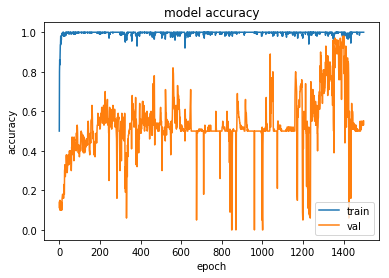

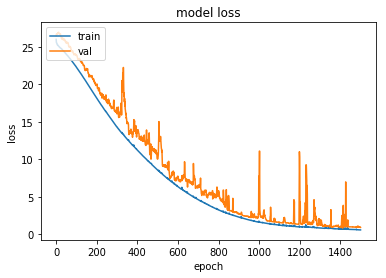

In [179]:
print(d_loss.history.keys())
# summarize history for accuracy
plt.plot(d_loss.history['acc'])
plt.plot(d_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(d_loss.history['loss'])
plt.plot(d_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:
for i in range(1,7):
    j=1
    while(j<i):
      print(j,end =" ")
      j+=1
    print('\n')
    



1 

1 2 

1 2 3 

1 2 3 4 

1 2 3 4 5 



In [0]:
print("-")

-


In [0]:
p=[1.0,2.0,3.0]*2

In [258]:
300000

60000.0

In [287]:
80000

80000

In [95]:
a = 10.3
c= a/5
c

2.06

In [94]:
for i in range(0, int(c)):
    print(i)

0
1


In [ ]:
BATCH_NORM = 1
    model.add(Conv2D(8, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', input_shape=(128,94,1), name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(8, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01),padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(2048))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2048, name='fc2'))
    